# **Spatial Transcriptomics Deep Learning (STDL) Project Notebook**

> The notebook contains main experiments and examples of how to use the code

## **Phase 1: Pre-processing and technical preparations**

### 1.1: **Assign GPU device and allow CUDA debugging**

In [1]:
# create code to reimport module if i change it
%load_ext autoreload

In [2]:
# the next 2 lines are to allow debugging with CUDA !
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  
print(f'cuda debugging allowed')

cuda debugging allowed


In [3]:
%%time

import torch
print(f'cuda device count: {torch.cuda.device_count()}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(f'device name: {torch.cuda.get_device_name(0)}')
    print(f'torch.cuda.device(0): {torch.cuda.device(0)}')
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
# NOTE: important !!!!!!
# clearing out the cache before beginning
torch.cuda.empty_cache()

cuda device count: 1
Using device: cuda
device name: GeForce RTX 2080 Ti
torch.cuda.device(0): <torch.cuda.device object at 0x7f9ed1eeefd0>
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
CPU times: user 2.18 s, sys: 3.98 s, total: 6.16 s
Wall time: 9.59 s


### 1.2: **Import the Pre-Process module**

> `loadAndPreProcess` module contains methods to load the data files as pytorch and pandas objects, methods to preprocess the given data, and methods to create custom datasets from the preprocessed data.

<div class="alert alert-block alert-warning">
<b>TODO:</b> fill above line
</div>

In [4]:
# note: path to project is: /home/roy.rubin/STDLproject/
%autoreload 2
import loadAndPreProcess

### 1.3: **Load pytorch dataset objects from the image folder**

> loading regular and augmented datasets created from the given image folder with transformations.

> Note: `augmentedImageFolder` is a custom dataset of imageFolder objects with different transformations (see code).

> Note: `im_hight_and_width_size` will define the size to which the images in the folder will be resized to. their original size 176, and so if the number will be bigger, the images will be automaticaly upsampled in the `resize` (not sure by what method) - which means images might be "pixelized" / lower quality. The problem is, size 176 doesnt work with all models, so i had to increase the size.

In [5]:
im_hight_and_width_size = 176  # values: 176 (doesnt work with inception) / 224 (doesnt work with inception) / 299 (works with inception)

In [6]:
%%time

path_to_images_dir_patient1_train = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient1/images"
imageFolder_train = loadAndPreProcess.load_dataset_from_images_folder(path_to_images_dir_patient1_train, im_hight_and_width_size)
augmentedImageFolder_train = loadAndPreProcess.load_augmented_imageFolder_DS_from_images_folder(path_to_images_dir_patient1_train, im_hight_and_width_size)


----- entered function load_dataset_from_pictures_folder -----

----- finished function load_dataset_from_pictures_folder -----


----- entered function load_dataset_from_pictures_folder -----

----- finished function load_dataset_from_pictures_folder -----

CPU times: user 212 ms, sys: 28.6 ms, total: 240 ms
Wall time: 257 ms


In [7]:
%%time

path_to_images_dir_patient2_test = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient2/images"
imageFolder_test = loadAndPreProcess.load_dataset_from_images_folder(path_to_images_dir_patient2_test, im_hight_and_width_size)
# augmentedImageFolder_test = loadAndPreProcess.load_augmented_imageFolder_DS_from_images_folder(path_to_images_dir_patient2_test, im_hight_and_width_size) # not needed for now


----- entered function load_dataset_from_pictures_folder -----

----- finished function load_dataset_from_pictures_folder -----

CPU times: user 55.8 ms, sys: 115 ms, total: 171 ms
Wall time: 1.05 s


### 1.4: **Load pandas dataframe objects from the given mtx/tsv/csv files**

> `matrix_dataframe` represents the gene expression count values of each sample for each gene

> `features_dataframe` contains the names of all the genes

> `barcodes_dataframe` contains the names of all the samples

In [8]:
%%time

path_to_mtx_tsv_files_dir_patient1_train = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient1"
matrix_dataframe_train, features_dataframe_train , barcodes_dataframe_train = loadAndPreProcess.load_dataframes_from_mtx_and_tsv_new(path_to_mtx_tsv_files_dir_patient1_train)


----- entered function load_dataframes_from_mtx_and_tsv -----
started reading features.tsv
V  finished reading features.tsv
started reading barcodes.tsv
V  finished reading barcodes.tsv
started reading matrix.mtx. this might take some time ...
V  finished reading matrix.mtx
adjusting matrix_dataframe
V  finished working on matrix_dataframe

----- finished function load_dataframes_from_mtx_and_tsv -----

CPU times: user 1min 53s, sys: 2.1 s, total: 1min 55s
Wall time: 2min


In [9]:
%%time

path_to_mtx_tsv_files_dir_patient2_test = "/home/roy.rubin/STDLproject/spatialGeneExpressionData/patient2"
matrix_dataframe_test, features_dataframe_test , barcodes_dataframe_test = loadAndPreProcess.load_dataframes_from_mtx_and_tsv_new(path_to_mtx_tsv_files_dir_patient2_test)


----- entered function load_dataframes_from_mtx_and_tsv -----
started reading features.tsv
V  finished reading features.tsv
started reading barcodes.tsv
V  finished reading barcodes.tsv
started reading matrix.mtx. this might take some time ...
V  finished reading matrix.mtx
adjusting matrix_dataframe
V  finished working on matrix_dataframe

----- finished function load_dataframes_from_mtx_and_tsv -----

CPU times: user 1min 45s, sys: 1.87 s, total: 1min 47s
Wall time: 1min 52s


### 1.5: **Remove samples from the matrix dataframe with no matching images in the image folder**

> Note: indices are being reset after this action, so a mapping of old to new column indices is returned: `column_mapping`.

> Note: the dataframe is also reordered according to the images order in the image folder

In [10]:
%%time

matrix_dataframe_train, column_mapping_train = loadAndPreProcess.cut_samples_with_no_matching_image_and_reorder_df(matrix_df=matrix_dataframe_train, 
                                                                                                                    image_folder_of_the_df=imageFolder_train, 
                                                                                                                    barcodes_df=barcodes_dataframe_train)

cutting samples that dont have mathching images in the image folder from the dataframe ...
V   done :)

CPU times: user 42.4 s, sys: 2.11 s, total: 44.5 s
Wall time: 46.4 s


In [11]:
%%time

matrix_dataframe_test, column_mapping_test = loadAndPreProcess.cut_samples_with_no_matching_image_and_reorder_df(matrix_df=matrix_dataframe_test, 
                                                                                                                  image_folder_of_the_df=imageFolder_test, 
                                                                                                                  barcodes_df=barcodes_dataframe_test)

cutting samples that dont have mathching images in the image folder from the dataframe ...
V   done :)

CPU times: user 42.2 s, sys: 1.83 s, total: 44 s
Wall time: 45.8 s


### 1.6: **Remove less-informative genes**

> we define *less-informative* genes as genes with less than K counts over all samples

> `Base_value` is a parameter for the user's choice

> Note: indices are being reset after this action, so a mapping of old to new column indices is returned: `row_mapping`.

In [12]:
# %%time

# Base_value = 10
# matrix_dataframe_train, row_mapping_train = loadAndPreProcess.cut_genes_with_under_B_counts(matrix_dataframe_train, Base_value) 

In [13]:
# %%time

# Base_value = 1
# matrix_dataframe_test, row_mapping_test = loadAndPreProcess.cut_genes_with_under_B_counts(matrix_dataframe_test, Base_value) 
# #TODO: note that this actually is not really needed, but it is to not change the functions inside this class to adjust to the test data

In [14]:
%%time

# begin by asserting that our dataframes have the same genes to begin with using the metadata of features_dataframe
assert features_dataframe_train['gene_names'].equals(features_dataframe_test['gene_names'])

Base_value = 10
matrix_dataframe_train, matrix_dataframe_test, row_mapping = loadAndPreProcess.cut_genes_with_under_B_counts_from_train_and_test(matrix_dataframe_train, matrix_dataframe_test, Base_value) 

checking for genes (rows) that contain less than B counts in both dataframes ...
discarding relevant rows ...
CPU times: user 53.8 s, sys: 2.88 s, total: 56.7 s
Wall time: 59.4 s


### 1.7: **Normalize matrix_dataframe entries**

> normaliztion will be performed on the remainning rows of the dataframe with the logic "log 1P"

> This method Calculates log(1 + x)

In [15]:
%%time

matrix_dataframe_train = loadAndPreProcess.perform_log_1p_normalization(matrix_dataframe_train) 

performing log1P transformation of the dataframe ...

CPU times: user 1.87 s, sys: 87.2 ms, total: 1.96 s
Wall time: 2.02 s


In [16]:
%%time

matrix_dataframe_test = loadAndPreProcess.perform_log_1p_normalization(matrix_dataframe_test) 

performing log1P transformation of the dataframe ...

CPU times: user 2.18 s, sys: 191 ms, total: 2.37 s
Wall time: 2.57 s


### 1.8: **Create custom datasets**

> Each custom dataset is tailored per task

> there are four tasks: single gene prediction, k gene prediction, all gene prediction using NMF dim. reduction, all gene prediction using AE dim. reduction

> For each of the above tasks 2 datasets were created:

>> A Dataset created from the TRAIN data WITHOUT augmentation (without image transformations)

>> A Dataset created from the TRAIN data WITH augmentation (with image transformations)

>> A Dataset created from the TEST data WITHOUT augmentation (without image transformations)

In [17]:
%%time
gene_name = 'MKI67'
custom_DS_SingleValuePerImg = loadAndPreProcess.STDL_Dataset_SingleValuePerImg(imageFolder=imageFolder_train, 
                                                               matrix_dataframe=matrix_dataframe_train, 
                                                               features_dataframe=features_dataframe_train, 
                                                               barcodes_dataframe=barcodes_dataframe_train, 
                                                               column_mapping=column_mapping_train,
                                                               row_mapping=row_mapping,
                                                               chosen_gene_name=gene_name)
custom_DS_SingleValuePerImg_augmented = loadAndPreProcess.STDL_Dataset_SingleValuePerImg(imageFolder=augmentedImageFolder_train, 
                                                               matrix_dataframe=matrix_dataframe_train, 
                                                               features_dataframe=features_dataframe_train, 
                                                               barcodes_dataframe=barcodes_dataframe_train, 
                                                               column_mapping=column_mapping_train,
                                                               row_mapping=row_mapping,
                                                               chosen_gene_name=gene_name)
custom_DS_SingleValuePerImg_test = loadAndPreProcess.STDL_Dataset_SingleValuePerImg(imageFolder=imageFolder_test, 
                                                               matrix_dataframe=matrix_dataframe_test, 
                                                               features_dataframe=features_dataframe_test, 
                                                               barcodes_dataframe=barcodes_dataframe_test, 
                                                               column_mapping=column_mapping_test,
                                                               row_mapping=row_mapping,
                                                               chosen_gene_name=gene_name)


----- entering __init__ phase of  STDL_Dataset_SingleValuePerImg -----

----- finished __init__ phase of  STDL_Dataset_SingleValuePerImg -----


----- entering __init__ phase of  STDL_Dataset_SingleValuePerImg -----

----- finished __init__ phase of  STDL_Dataset_SingleValuePerImg -----


----- entering __init__ phase of  STDL_Dataset_SingleValuePerImg -----

----- finished __init__ phase of  STDL_Dataset_SingleValuePerImg -----

CPU times: user 953 ms, sys: 119 ms, total: 1.07 s
Wall time: 1.11 s


<div class="alert alert-block alert-info">
<b>Note:</b> inside the init phase of `STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance` class, K genes with the highest variance are chosen from matrix_dataframe, and they are the only genes that are kept for training and testing purposes
</div>

In [18]:
%%time

k = 10
custom_DS_KGenesWithHighestVariance = loadAndPreProcess.STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance(imageFolder=imageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k)
custom_DS_KGenesWithHighestVariance_augmented = loadAndPreProcess.STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance(imageFolder=augmentedImageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k)
custom_DS_KGenesWithHighestVariance_test = loadAndPreProcess.STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance(imageFolder=imageFolder_test, 
                                                                           matrix_dataframe=matrix_dataframe_test, 
                                                                           features_dataframe=features_dataframe_test, 
                                                                           barcodes_dataframe=barcodes_dataframe_test, 
                                                                           column_mapping=column_mapping_test,
                                                                           num_of_dims_k=k)


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance -----
calculate variance of all columns from  matrix_dataframe - and choosing K genes with higest variance ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance -----
calculate variance of all columns from  matrix_dataframe - and choosing K genes with higest variance ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_KGenesWithHighestVariance -----
calculate variance of all columns from  matrix_dataframe - and choosing K genes with higest variance ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----

CPU times: user 27.5 s, sys: 2.4 s, total: 29.9 s
Wall time: 31 s


<div class="alert alert-block alert-info">
<b>Note:</b> inside the init phase of `STDL_Dataset_KValuesPerImg_LatentTensor_NMF` class, an NMF decompositionis performed on the matrix_dataframe object
</div>

In [19]:
%%time

k = 10
custom_DS_LatentTensor_NMF = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_NMF(imageFolder=imageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k)
custom_DS_LatentTensor_NMF_augmented = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_NMF(imageFolder=augmentedImageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k)
custom_DS_LatentTensor_NMF_test = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_NMF(imageFolder=imageFolder_test, 
                                                                           matrix_dataframe=matrix_dataframe_test, 
                                                                           features_dataframe=features_dataframe_test, 
                                                                           barcodes_dataframe=barcodes_dataframe_test, 
                                                                           column_mapping=column_mapping_test,
                                                                           num_of_dims_k=k)


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_NMF -----
performing NMF decomposition on main matrix dataframe ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_NMF -----
performing NMF decomposition on main matrix dataframe ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_NMF -----
performing NMF decomposition on main matrix dataframe ...

----- finished __init__ phase of  STDL_Dataset_LatentTensor -----

CPU times: user 24min 24s, sys: 16min 35s, total: 41min
Wall time: 1min 22s


<div class="alert alert-block alert-info">
<b>Note:</b> 
<ul>
  <li>first we create a dataset from `matrix_dataframe_train` to feed our AEnet.</li>
  <li>Then we create our AEnet and train it.</li>
  <li>Finally, we create our `custom_DS_LatentTensor_AE` class, in which the Autoencoder network will be saved.</li>
</ul>
</div>

In [20]:
dataset_from_matrix_df = loadAndPreProcess.STDL_Dataset_matrix_df_for_AE_init(matrix_dataframe_train)

In [21]:
%autoreload 2

from executionModule import get_Trained_AEnet
k = 10
AEnet = get_Trained_AEnet(dataset_from_matrix_df=dataset_from_matrix_df, z_dim=k, num_of_epochs=3, device=device)


----- entered function return_trained_AE_net -----
note - number of (hidden) linear layers is supposed to be 3

entered __init__ of AutoencoderNet
****** begin training ******

iteration 1 of 3 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.0127635532990098 max loss 1.0060787200927734
               average loss 0.1140093217273393

iteration 2 of 3 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.011536810547113419 max loss 0.22284650802612305
               average loss 0.10551176326500324

iteration 3 of 3 epochs
batch 3813 of 3813 batches
finished inner loop.

in this epoch: min loss 0.011026603169739246 max loss 0.20367717742919922
               average loss 0.10407850408568536

----- finished function return_trained_AE_net -----



In [22]:
%%time

k = 10
custom_DS_LatentTensor_AE = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder(imageFolder=imageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           AEnet=AEnet,
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k,
                                                                           device=device)
custom_DS_LatentTensor_AE_augmented = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder(imageFolder=augmentedImageFolder_train, 
                                                                           matrix_dataframe=matrix_dataframe_train, 
                                                                           features_dataframe=features_dataframe_train, 
                                                                           barcodes_dataframe=barcodes_dataframe_train, 
                                                                           AEnet=AEnet,                                                                                                            
                                                                           column_mapping=column_mapping_train,
                                                                           num_of_dims_k=k,
                                                                           device=device)
custom_DS_LatentTensor_AE_test = loadAndPreProcess.STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder(imageFolder=imageFolder_test, 
                                                                           matrix_dataframe=matrix_dataframe_test, 
                                                                           features_dataframe=features_dataframe_test, 
                                                                           barcodes_dataframe=barcodes_dataframe_test, 
                                                                           AEnet=AEnet,                                                                                                       
                                                                           column_mapping=column_mapping_test,
                                                                           num_of_dims_k=k,
                                                                           device=device)


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----
initializing the autoencoder (this might take a while) ...

----- finished __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----
initializing the autoencoder (this might take a while) ...

----- finished __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----


----- entering __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----
initializing the autoencoder (this might take a while) ...

----- finished __init__ phase of  STDL_Dataset_KValuesPerImg_LatentTensor_AutoEncoder -----

CPU times: user 1.8 s, sys: 19.2 s, total: 21 s
Wall time: 22.1 s


### 1.9: prepare for the next phases in which the experiments are executed

> import `executionModule` which contains the experiments, training methods, and testing methods

> create `hyperparameters` dictionary which will contain all of the hyper-parameters for our experiments (note - user can change these later)

> create `model_list` that will hold all the names for the models that will be used (only 3 models for now, as can be seen below). the models are:

>> `BasicConvNet` model

>> `DensetNet121` model

>> `Inception_V3` model

<div class="alert alert-block alert-warning">
<b>Warning:</b> change the hyper-parameters below with caution if needed !
</div>

In [23]:
%autoreload 2
import executionModule

# define hyperparameters for the experiments
hyperparameters = dict()
hyperparameters['batch_size'] = 25
hyperparameters['max_alowed_number_of_batches'] = 99999
hyperparameters['precent_of_dataset_allocated_for_training'] = 0.8
hyperparameters['learning_rate'] = 1e-4
hyperparameters['momentum'] = 0.9
hyperparameters['num_of_epochs'] = 3

# define hyperparameters for BsicConvNet
hyperparameters['channels'] = [32] 
hyperparameters['num_of_convolution_layers'] = len(hyperparameters['channels'])
hyperparameters['hidden_dims'] = [100]
hyperparameters['num_of_hidden_layers'] = len(hyperparameters['hidden_dims'])
hyperparameters['pool_every'] = 99999

# list of all models used
model_list = []
model_list.append('BasicConvNet')
model_list.append('DensetNet121')
# model_list.append('Inception_V3')  #TODO: still need to sort out input image size... !

<div class="alert alert-block alert-danger">
<b>Note:</b> inception_v3 model isnt sorted out yet... gives
    RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (5 x 5). Kernel size can't be greater than actual input size
</div>

> creating an assisting method for our testing that will time each experiment

In [24]:
def experiment_loop(ds_train, ds_test, phase_name):
    for model_name in model_list:
        print(f'\nstarting experiment **{model_name}**\n')
        %time executionModule.runExperiment(ds_train=ds_train, ds_test=ds_test, hyperparams=hyperparameters, device=device, model_name=model_name, dataset_name=phase_name)
        print(f'\nfinished experiment {model_name}')
    

## Phase 2: Single Gene Prediction


starting experiment **BasicConvNet**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 4.1480508997154075

iteration 2 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 0.24410368943292843

iteration 3 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 0.21795833022578767
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getSingleDimPrediction -----
--delete-- verify:  M_pred.shape (4015,)  ~  M_truth.shape (4015,)

----- finished function getSingleDimPrediction -----
TODO: print comparison of error results
recieved M_fast_reconstruction=None. errors with it will be 0
distance between M_truth, M_pred: 34.43702292482944
distance between M_truth,

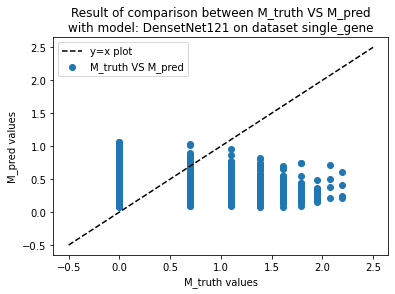

In [25]:
experiment_loop(ds_train=custom_DS_SingleValuePerImg ,ds_test=custom_DS_SingleValuePerImg_test ,phase_name='single_gene')


starting experiment **BasicConvNet**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.5842790643211271

iteration 2 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.23884593719219574

iteration 3 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.22119824710439462
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getSingleDimPrediction -----
--delete-- verify:  M_pred.shape (4015,)  ~  M_truth.shape (4015,)

----- finished function getSingleDimPrediction -----
TODO: print comparison of error results
recieved M_fast_reconstruction=None. errors with it will be 0
distance between M_truth, M_pred: 35.42027152930368
distance between M_

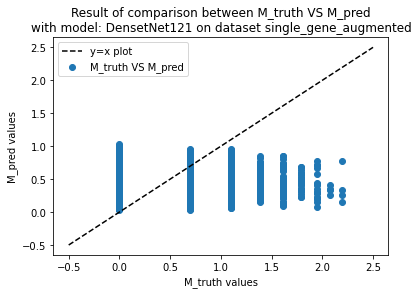

In [26]:
experiment_loop(ds_train=custom_DS_SingleValuePerImg_augmented ,ds_test=custom_DS_SingleValuePerImg_test ,phase_name='single_gene_augmented')

## Phase 3: K genes prediction

In [27]:
experiment_loop(ds_train=custom_DS_KGenesWithHighestVariance ,ds_test=custom_DS_KGenesWithHighestVariance_test ,phase_name='k_genes')


starting experiment **BasicConvNet**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 1.683421716094017

iteration 2 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 1.043366709037831

iteration 3 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 0.904226440740259
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getKDimPrediction -----
--delete-- verify:  M_pred.shape (4015, 10)  ~  M_truth.shape (4015, 10)

----- finished function getKDimPrediction -----
TODO: print comparison of error results
recieved M_fast_reconstruction=None. errors with it will be 0
distance between M_truth, M_pred: 433.3573307098388
distance between M_truth, M_fast_r

In [28]:
experiment_loop(ds_train=custom_DS_KGenesWithHighestVariance_augmented ,ds_test=custom_DS_KGenesWithHighestVariance_test ,phase_name='k_genes_augmented')


starting experiment **BasicConvNet**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 1.1920923530078325

iteration 2 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.8629033511046503

iteration 3 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.6593030682108442
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getKDimPrediction -----
--delete-- verify:  M_pred.shape (4015, 10)  ~  M_truth.shape (4015, 10)

----- finished function getKDimPrediction -----
TODO: print comparison of error results
recieved M_fast_reconstruction=None. errors with it will be 0
distance between M_truth, M_pred: 440.84960663747256
distance between M_truth

## Phase 4: All genes prediction - using dimensionality reduction techniques

### 4.1: Prediction using dimensionality reduction technique NMF

In [29]:
experiment_loop(ds_train=custom_DS_LatentTensor_NMF ,ds_test=custom_DS_LatentTensor_NMF_test ,phase_name='NMF')


starting experiment **BasicConvNet**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 0.9715351260169164

iteration 2 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 0.11062219447309249

iteration 3 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 0.1092799044165172
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getFullDimsPrediction_with_NMF_DS -----
--delete-- verify: W_prepared.shape (18077, 10), y_pred_prepared.shape (10, 3813)
--delete-- verify:  M_pred.shape (18077, 3813)  ~  M_truth.shape (18077, 3813)

----- finished function getKDimPrediction -----
TODO: print comparison of error results
distance between M_truth, M_pred: 4844.9

In [30]:
experiment_loop(ds_train=custom_DS_LatentTensor_NMF_augmented ,ds_test=custom_DS_LatentTensor_NMF_test ,phase_name='NMF_augmented')


starting experiment **BasicConvNet**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.14525805357843638

iteration 2 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.09649317733271688

iteration 3 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.084102328463656
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getFullDimsPrediction_with_NMF_DS -----
--delete-- verify: W_prepared.shape (18077, 10), y_pred_prepared.shape (10, 30504)
--delete-- verify:  M_pred.shape (18077, 30504)  ~  M_truth.shape (18077, 3813)


AssertionError: 


finished experiment BasicConvNet

starting experiment **DensetNet121**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.05743554156945377

iteration 2 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.048477902628298174

iteration 3 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 0.044420166403726966
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getFullDimsPrediction_with_NMF_DS -----
--delete-- verify: W_prepared.shape (18077, 10), y_pred_prepared.shape (10, 30504)
--delete-- verify:  M_pred.shape (18077, 30504)  ~  M_truth.shape (18077, 3813)


AssertionError: 


finished experiment DensetNet121


### 4.2: Prediction using dimensionality reduction technique AE

In [31]:
experiment_loop(ds_train=custom_DS_LatentTensor_AE ,ds_test=custom_DS_LatentTensor_AE_test ,phase_name='AE')


starting experiment **BasicConvNet**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 2.5388931192849813

iteration 2 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 1.9609106194816137

iteration 3 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 1.7250897123625404
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getFullDimsPrediction_with_AE_DS -----
printing information about the dataset:
size of the dataset (==number of images in the image folder) 3813
num_of_samples_matrix_df in the dataset (==number of columns in matrix_dataframe) 3813
num_of_features_matrix_df in the dataset (==number of rows in matrix_dataframe) 18077
--delete-- ve

AssertionError: 


finished experiment BasicConvNet

starting experiment **DensetNet121**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 2.750806599855423

iteration 2 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 1.7471459774594558

iteration 3 of 3 epochs
batch 152 of 152 batches
finished inner loop.
in this epoch: average loss 1.609512571049364
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getFullDimsPrediction_with_AE_DS -----
printing information about the dataset:
size of the dataset (==number of images in the image folder) 3813
num_of_samples_matrix_df in the dataset (==number of columns in matrix_dataframe) 3813
num_of_features_matrix_df in the dataset (==number of rows in matri

AssertionError: 


finished experiment DensetNet121


In [ ]:
experiment_loop(ds_train=custom_DS_LatentTensor_AE_augmented ,ds_test=custom_DS_LatentTensor_AE_test ,phase_name='AE_augmented')


starting experiment **BasicConvNet**


----- entered function runExperimentWithModel_BasicConvNet -----
/ * \ ENTERED train_prediction_model / * \ 
****** begin training ******

iteration 1 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 1.9661790026015922

iteration 2 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 1.513339985003237

iteration 3 of 3 epochs
batch 1220 of 1220 batches
finished inner loop.
in this epoch: average loss 1.0845200430418624
finished all epochs !
which means, that this model is now trained.
 \ * / FINISHED train_prediction_model \ * / 

----- entered function getFullDimsPrediction_with_AE_DS -----
printing information about the dataset:
size of the dataset (==number of images in the image folder) 30504
num_of_samples_matrix_df in the dataset (==number of columns in matrix_dataframe) 3813
num_of_features_matrix_df in the dataset (==number of rows in matrix_dataframe) 18077


<div class="alert alert-block alert-danger">
<b>Note:</b> testing blocks
</div>